# Import library

In [2]:
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras import backend as K

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Get dataset and preprocessing

In [3]:
# Set dataset path
train_img = '/content/drive/My Drive/image project/train_set/Images/'
train_mask = '/content/drive/My Drive/image project/train_set/Masks'
val_img = '/content/drive/My Drive/image project/val_set/Images'
val_mask = '/content/drive/My Drive/image project/val_set/Masks'
test_img = '/content/drive/My Drive/image project/test_set'

In [4]:
Img_h = 256
Img_w = 256
test = ImageDataGenerator(rescale=1/255)

In [5]:
data_gen_args = dict(rescale = 1/255,
                     rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)


seed = 1

train_image_generator = image_datagen.flow_from_directory(
    train_img,
    class_mode=None,
    target_size=(Img_h,Img_w),
    seed=seed)

train_mask_generator = mask_datagen.flow_from_directory(
    train_mask,
    class_mode=None,
    color_mode='grayscale',
    target_size=(Img_h,Img_w),
    seed=seed)

val_image_generator = image_datagen.flow_from_directory(
    val_img,
    class_mode=None,
    target_size=(Img_h,Img_w),
    seed=seed)

val_mask_generator = mask_datagen.flow_from_directory(
    val_mask,
    class_mode=None,
    color_mode='grayscale',
    target_size=(Img_h,Img_w),
    seed=seed)

test_dataset = test.flow_from_directory(test_img,
                                        target_size=(Img_h,Img_w),
                                        batch_size = 1,
                                        class_mode = None)

Found 605 images belonging to 1 classes.
Found 605 images belonging to 1 classes.
Found 99 images belonging to 1 classes.
Found 99 images belonging to 1 classes.
Found 96 images belonging to 1 classes.


In [6]:
train_generator = zip(train_image_generator,train_mask_generator)
val_generator = zip(val_image_generator,val_mask_generator)

# Create model

In [7]:
def cnn_block(layer, filters, ksize):
  layer = Conv2D(filters, ksize, activation='relu', padding='same', kernel_initializer='he_normal')(layer)
  return layer


In [8]:
def Unet(input_shape):
  input = Input(shape=input_shape)
  conv1 = cnn_block(input, 16,3)
  drop1 = Dropout(0.1)(conv1)
  conv11 = cnn_block(drop1, 16,3)
  pool1 = MaxPooling2D(pool_size=(2,2))(conv11)

  conv2 = cnn_block(pool1, 32,3)
  drop2 = Dropout(0.1)(conv2)
  conv22 = cnn_block(drop2, 32,3)
  pool2 = MaxPooling2D(pool_size=(2,2))(conv22)

  conv3 = cnn_block(pool2, 64,3)
  drop3 = Dropout(0.2)(conv3)
  conv33 = cnn_block(drop3, 64,3)
  pool3 = MaxPooling2D(pool_size=(2,2))(conv33)

  conv4 = cnn_block(pool3, 128,3)
  drop4 = Dropout(0.2)(conv4)
  conv44 = cnn_block(drop4, 128,3)
  pool4 = MaxPooling2D(pool_size=(2,2))(conv44)

  conv5 = cnn_block(pool4, 256,3)
  drop5 = Dropout(0.3)(conv5)
  conv55 = cnn_block(drop5, 256,3)

  up6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(conv55)
  merge6 = concatenate([up6,conv44])
  conv6 = cnn_block(merge6, 128, 3)
  drop6 = Dropout(0.2)(conv6)
  conv66 = cnn_block(drop6, 128, 3)

  up7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(conv66)
  merge7 = concatenate([up7,conv33])
  conv7 = cnn_block(merge7, 64,3)
  drop7 = Dropout(0.2)(conv7)
  conv77 = cnn_block(drop7, 64,3)

  up8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(conv77)
  merge8 = concatenate([up8,conv22])
  conv8 = cnn_block(merge8, 32,3)
  drop8 = Dropout(0.1)(conv8)
  conv88 = cnn_block(drop8, 32,3)

  up9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(conv88)
  merge9 = concatenate([up9,conv11], axis=3)
  conv9 = cnn_block(merge9, 16,3)
  drop9 = Dropout(0.1)(conv9)
  conv99 = cnn_block(drop9, 16,3)

  output = Conv2D(1, 1, activation='sigmoid')(conv99)

  model = Model(input,output)
  return model

In [9]:
model = Unet((256,256,3))

In [10]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        dropout[0][0]                    
_______________________________________________________________________________________

In [108]:
def mIoU(y_true, y_pred):
  y_pred = K.cast(K.greater(y_pred, .5), dtype='float32')
  intersection = K.sum(y_true * y_pred)
  sum_ = K.sum(y_true + y_pred)
  jac = (intersection) / (sum_ - intersection )
  return K.mean(jac)

def miou_np(y_true, y_pred, thresh):
  y_pred = np.where(y_pred>thresh, 1,0)
  intersection = np.sum(y_true * y_pred)
  sum_ = np.sum(y_true + y_pred)
  jac = (intersection) / (sum_ - intersection)
  return np.mean(jac)

In [ ]:
model.compile(loss='binary_crossentropy', metrics=['accuracy',mIoU], optimizer='adam')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Run model

In [ ]:

history = model.fit(train_generator,
                    validation_data=val_generator,
                    validation_steps=30,
                    steps_per_epoch=30,
                    epochs=100,
                    shuffle=True,
                    callbacks=[stop])

Epoch 1/100
30/30 [==============================] - 301s 10s/step - loss: 0.6138 - accuracy: 0.7198 - mIoU: 0.0326 - val_loss: 0.5377 - val_accuracy: 0.7387 - val_mIoU: 0.0343
Epoch 2/100
30/30 [==============================] - 295s 10s/step - loss: 0.4408 - accuracy: 0.8014 - mIoU: 0.3527 - val_loss: 0.3824 - val_accuracy: 0.8357 - val_mIoU: 0.3928
Epoch 3/100
30/30 [==============================] - 299s 10s/step - loss: 0.2467 - accuracy: 0.8975 - mIoU: 0.6809 - val_loss: 0.3339 - val_accuracy: 0.8702 - val_mIoU: 0.5394
Epoch 4/100
30/30 [==============================] - 297s 10s/step - loss: 0.2583 - accuracy: 0.8994 - mIoU: 0.6896 - val_loss: 0.2862 - val_accuracy: 0.8821 - val_mIoU: 0.5863
Epoch 5/100
30/30 [==============================] - 302s 10s/step - loss: 0.2251 - accuracy: 0.9089 - mIoU: 0.7225 - val_loss: 0.3120 - val_accuracy: 0.8765 - val_mIoU: 0.5563
Epoch 6/100
30/30 [==============================] - 295s 10s/step - loss: 0.2249 - accuracy: 0.9108 - mIoU: 0.7269

In [ ]:
# Save model
model.save('/content/drive/My Drive/image project/project_model.h5')

In [12]:
# Load model
from tensorflow import keras
model = keras.models.load_model('/content/drive/My Drive/image project/project_model.h5', custom_objects={'mIoU': mIoU})

# Evaluate 

In [13]:
def draw_chart(history):
  plt.figure(figsize=(15,8))

  plt.subplot(1,2,1)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Losses vs Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(['Train', 'Validation'])

  plt.subplot(1,2,2)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Accuracy vs Epoch')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['Train', 'Validation'])

  plt.show()

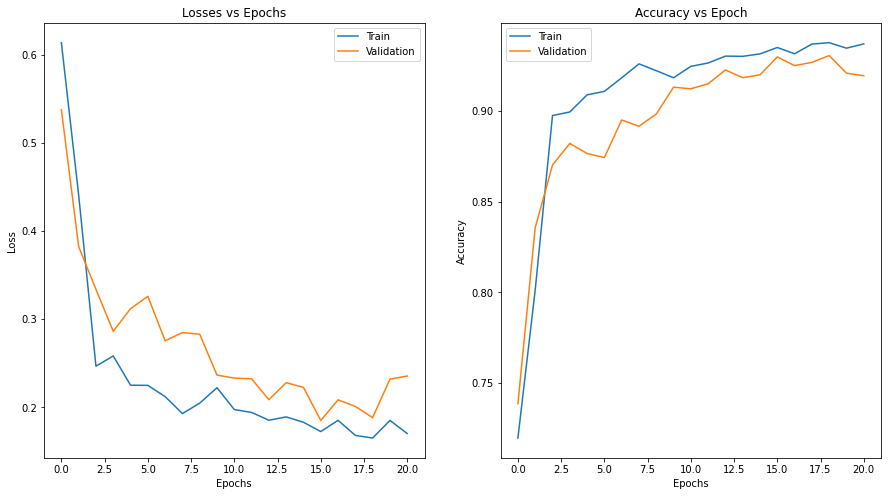

In [ ]:
draw_chart(history)

In [ ]:
model.evaluate(val_generator, steps=30)

30/30 [==============================] - 138s 5s/step - loss: 0.1635 - accuracy: 0.9350 - mIoU: 0.7774


[0.16347165405750275, 0.9350253939628601, 0.7774425745010376]

# Predict

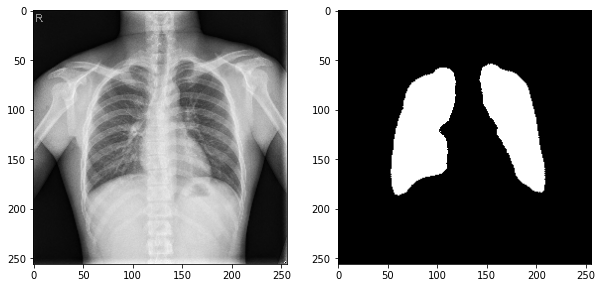

In [15]:
# predict test dataset
def plot_test(index):
  fig = plt.figure(figsize=(10,8))
  ax1 = fig.add_subplot(1,2,1)
  ax2 = fig.add_subplot(1,2,2)

  pred = model.predict(test_dataset[index])
  pred_t = (pred > 0.4).astype(np.uint8)
  ax1.imshow(np.reshape(test_dataset[index],[Img_h,Img_w,3]))
  ax2.imshow(np.squeeze(pred_t), cmap='gray')
  plt.show()

plot_test(66)

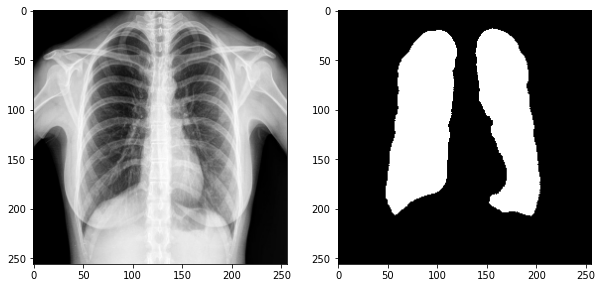

In [18]:
# predict outsourced image
def input_img(path):
  img1 = cv2.imread(path)
  img1 = cv2.resize(img1,(256,256))
  img1 = img1.astype(np.float32)/255
  img1 = img1[None,...]
  pred = model.predict(img1)

  fig = plt.figure(figsize=(10,8))
  ax1 = fig.add_subplot(1,2,1)
  ax2 = fig.add_subplot(1,2,2)

  pred_t = (pred > 0.4).astype(np.uint8)
  ax1.imshow(np.squeeze(img1))
  ax2.imshow(np.squeeze(pred_t), cmap='gray')
  plt.show()

input_img('/content/drive/My Drive/image project/anh_tren_mang.jpg')

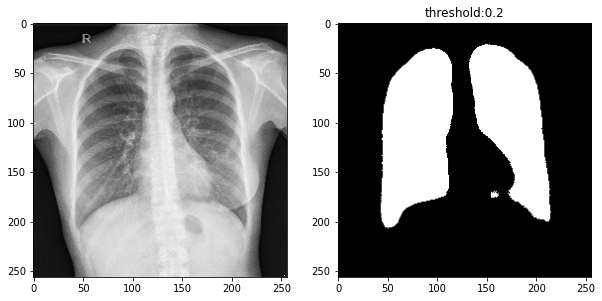

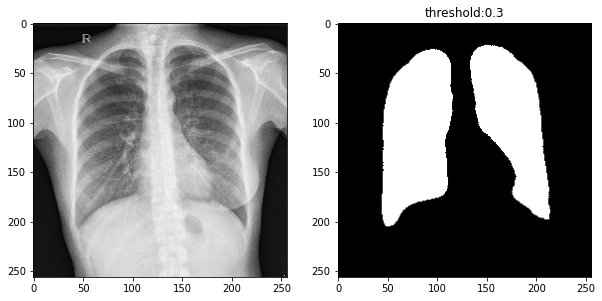

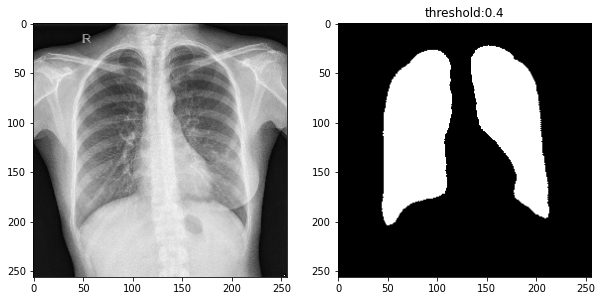

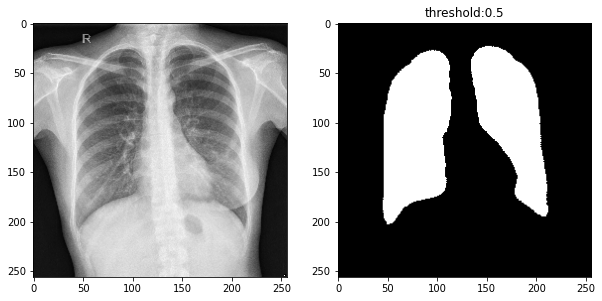

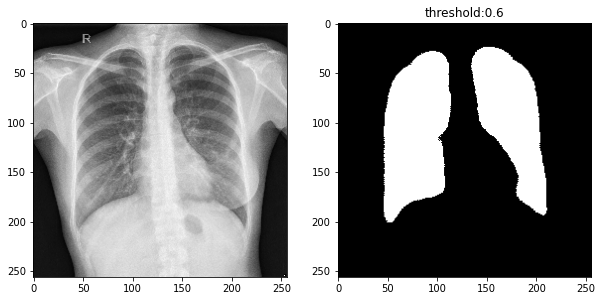

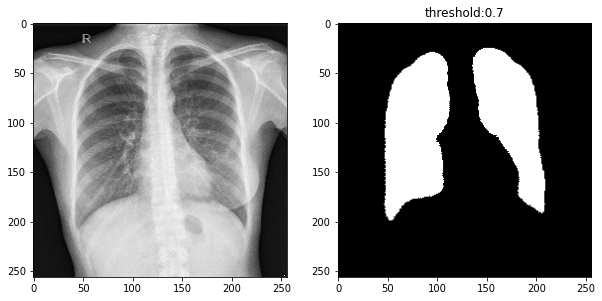

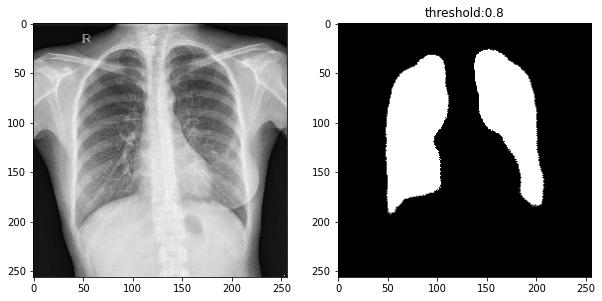

In [44]:
for i in range(2,9):
  fig = plt.figure(figsize=(10,8))
  ax1 = fig.add_subplot(1,2,1)
  ax2 = fig.add_subplot(1,2,2)

  pred = model.predict(test_dataset[1])
  pred_t = (pred > i/10).astype(np.uint8)
  ax1.imshow(np.reshape(test_dataset[1],[Img_h,Img_w,3]))
  ax2.imshow(np.squeeze(pred_t), cmap='gray')
  plt.title('threshold:'+ str(i/10))
  plt.show()

In [48]:
val_image1 = test.flow_from_directory(val_img,
                                        target_size=(Img_h,Img_w),
                                        batch_size = 1,
                                        class_mode = None)

Found 99 images belonging to 1 classes.


In [51]:
val_label1 = test.flow_from_directory(val_mask,
                                        target_size=(Img_h,Img_w),
                                      color_mode='grayscale',
                                        batch_size = 1,
                                        class_mode = None)

Found 99 images belonging to 1 classes.


In [50]:
val_image1[1].shape

(1, 256, 256, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.29156926912887643


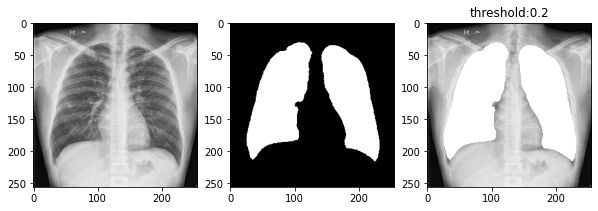

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.2893384842088494


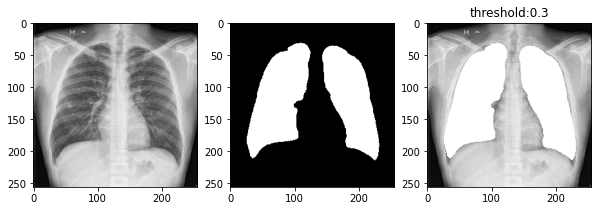

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.28754615915270054


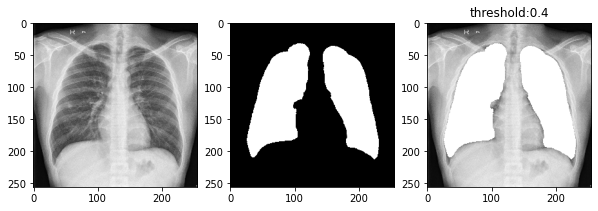

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.2859797646087136


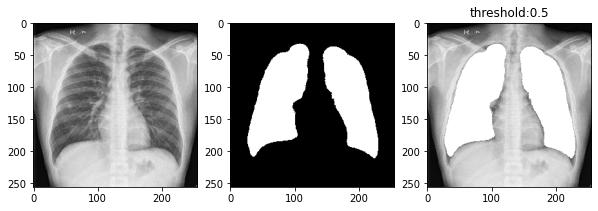

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.28295521632790754


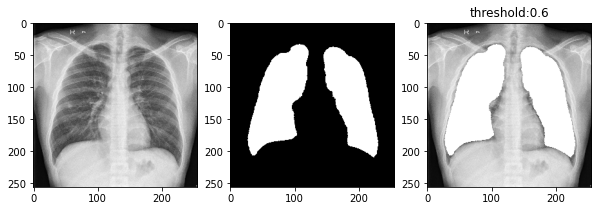

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.2789457581187989


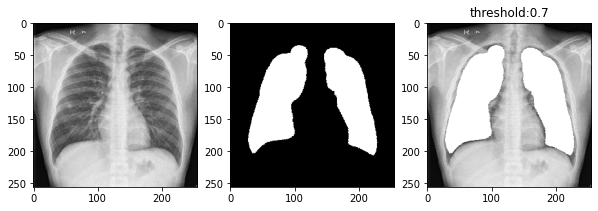

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.26979431476773746


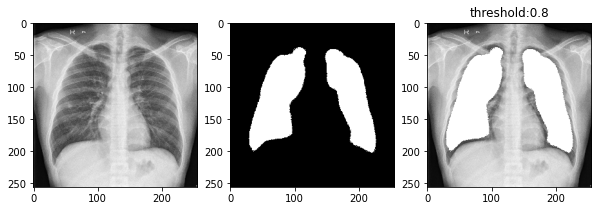

In [122]:
for i in range(2,9):
  fig = plt.figure(figsize=(10,8))
  ax1 = fig.add_subplot(1,3,1)
  ax2 = fig.add_subplot(1,3,2)
  ax3 = fig.add_subplot(1,3,3)
  pred = model.predict(val_image1[1])
  pred_t = np.where(pred > i/10,1,0)
  ax1.imshow(np.reshape(val_image1[1],[Img_h,Img_w,3]))
  ax2.imshow(np.squeeze(pred_t), cmap='gray')

  ax3.imshow(np.squeeze(pred_t + val_image1[1]))
  print(miou_np(val_label1[1],pred, i/10))
  plt.title('threshold:'+ str(i/10))
  plt.show()